In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

%matplotlib inline

In [2]:
train_x = Variable(torch.linspace(0, 1, 1000))
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
class KissGPModel(gpytorch.GPModel):
    def __init__(self):
        super(KissGPModel, self).__init__(GaussianLikelihood(log_noise_bounds=(-5, 5)))
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        covar_module = RBFKernel(log_lengthscale_bounds=(-3, 5))
        self.grid_covar_module = GridInterpolationKernel(covar_module)
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-1, 1))
        self.initialize_interpolation_grid(50, grid_bounds=[(0, 1)])

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.grid_covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)
    
model = KissGPModel()
model.condition(train_x, train_y)

KissGPModel (
  (likelihood): GaussianLikelihood (
  )
  (mean_module): ConstantMean (
  )
  (grid_covar_module): GridInterpolationKernel (
    (base_kernel_module): RBFKernel (
    )
  )
)

In [4]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 51))
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        if plot_train_data:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

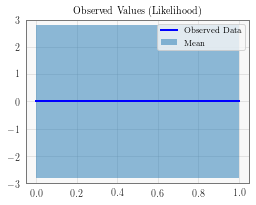

In [5]:
f = plot_model_and_predictions(model, plot_train_data=False)

In [6]:
# Optimize the model
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(30):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/30 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()

_ = model.eval()

/home/gpleiss/Dropbox/workspace/gpytorch/gpytorch/kernels/rbf_kernel.py:42: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  grad.mul_(grad_output.transpose(0, 1))


Iter 1/30 - Loss: 1152.147
Iter 2/30 - Loss: 1122.936
Iter 3/30 - Loss: 1093.935
Iter 4/30 - Loss: 1058.343
Iter 5/30 - Loss: 1030.104
Iter 6/30 - Loss: 1000.053
Iter 7/30 - Loss: 976.240
Iter 8/30 - Loss: 951.528
Iter 9/30 - Loss: 918.478
Iter 10/30 - Loss: 890.790
Iter 11/30 - Loss: 849.780
Iter 12/30 - Loss: 800.696
Iter 13/30 - Loss: 733.828
Iter 14/30 - Loss: 655.171
Iter 15/30 - Loss: 564.799
Iter 16/30 - Loss: 481.585
Iter 17/30 - Loss: 390.816
Iter 18/30 - Loss: 318.822
Iter 19/30 - Loss: 242.752
Iter 20/30 - Loss: 179.856
Iter 21/30 - Loss: 131.651
Iter 22/30 - Loss: 83.022
Iter 23/30 - Loss: 42.736
Iter 24/30 - Loss: 7.354
Iter 25/30 - Loss: -28.692
Iter 26/30 - Loss: -60.227
Iter 27/30 - Loss: -85.006
Iter 28/30 - Loss: -114.279
Iter 29/30 - Loss: -131.490
Iter 30/30 - Loss: -154.142


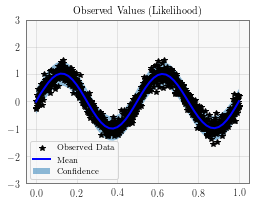

In [7]:
f = plot_model_and_predictions(model, plot_train_data=True)